<a href="https://colab.research.google.com/github/SD325/NASA_Internship_2020/blob/master/NASA_Simple_Models_Multi_Day.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Imports
import joblib
import pickle
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


# Working Directory 
BASE_DIR = '/content/drive/My Drive/data/NASA_2020/'

# Load and Split Data

In [3]:
with open(BASE_DIR + 'X_data_3_days.pkl', 'rb') as f:
  X = pickle.load(f)
  print(f'Loaded X. {X.shape}')

with open(BASE_DIR + 'y_data_3_days.pkl', 'rb') as f:
  y = pickle.load(f)
  print(f'Loaded y. {y.shape}')

Loaded X. (2185776, 21)
Loaded y. (2185776, 4)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
del X
del y
print(f"train: {X_train.shape} {y_train.shape}")
print(f"test: {X_test.shape} {y_test.shape}")

train: (1748620, 21) (1748620, 4)
test: (437156, 21) (437156, 4)


# SMOTE

In [5]:
from imblearn.under_sampling import RandomUnderSampler

rus_dict = {0: 45000}
rus = RandomUnderSampler(rus_dict, random_state=42)
X_res, y_res = rus.fit_sample(X_train, y_train)
print(X_res.shape, y_res.shape)

(98857, 21) (98857, 4)


In [6]:
from collections import Counter
print("original: ", Counter(np.argmax(y_train, axis=1)))
print("SMOTE: ", Counter(np.argmax(y_res, axis=1)))

original:  Counter({0: 1694763, 1: 46205, 3: 3961, 2: 3691})
SMOTE:  Counter({1: 46205, 0: 45000, 3: 3961, 2: 3691})


# Neural Network (MLP)

In [7]:
# weighted loss function
import keras.backend as K

def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    def weighted_loss(y_true, y_pred):
        loss = 0.0
        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            loss += K.mean(-(pos_weights[i]*y_true[:, i]*K.log(y_pred[:, i]+epsilon)
                             + neg_weights[i]*(1-y_true[:, i])*K.log((1-y_pred[:, i])+epsilon)))
        return loss
    return weighted_loss

neg_weights = np.mean(y_res, axis=0)
pos_weights = 1 - neg_weights

Using TensorFlow backend.


In [8]:
model = keras.models.Sequential([
        layers.InputLayer(input_shape=(21,)),
        layers.Dense(128, activation=tf.nn.relu), 
        layers.Dense(128, activation=tf.nn.relu),
        layers.Dense(32, activation=tf.nn.relu),
        layers.Dense(4, activation=tf.nn.softmax)
    ])

model.compile(optimizer='adam',
              loss=get_weighted_loss(pos_weights, neg_weights),
              metrics=['accuracy'])

In [9]:
history = model.fit(X_res, y_res, validation_data=(X_test, y_test), epochs=5)

Epoch 1/5
3090/3090 [==============================] - 21s 7ms/step - loss: 0.3402 - accuracy: 0.8612 - val_loss: 0.2153 - val_accuracy: 0.9030
Epoch 2/5
3090/3090 [==============================] - 22s 7ms/step - loss: 0.2967 - accuracy: 0.8764 - val_loss: 0.1963 - val_accuracy: 0.9142
Epoch 3/5
3090/3090 [==============================] - 21s 7ms/step - loss: 0.2831 - accuracy: 0.8823 - val_loss: 0.1835 - val_accuracy: 0.9121
Epoch 4/5
3090/3090 [==============================] - 22s 7ms/step - loss: 0.2752 - accuracy: 0.8850 - val_loss: 0.1682 - val_accuracy: 0.9256
Epoch 5/5
3090/3090 [==============================] - 21s 7ms/step - loss: 0.2670 - accuracy: 0.8882 - val_loss: 0.1797 - val_accuracy: 0.9218


In [10]:
y_pred = model.predict(X_test)

## Confusion Matrix

In [11]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

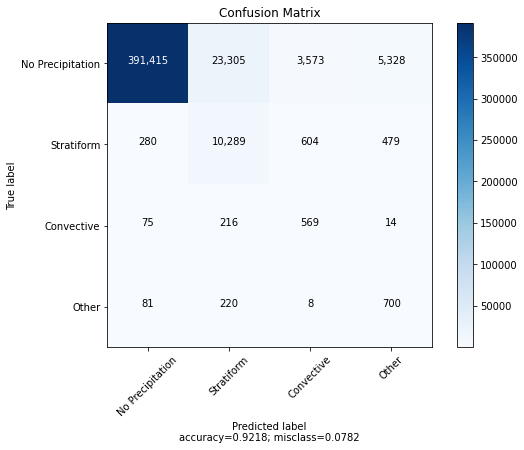

In [12]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

plot_confusion_matrix(cm           = conf_mat, 
                      normalize    = False,
                      target_names = ['No Precipitation', 'Stratiform', 'Convective', 'Other'],
                      title        = "Confusion Matrix")

## ROC Curves

In [13]:
from sklearn.metrics import roc_auc_score, roc_curve

def get_roc_curve(labels, y_true, y_pred):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = y_true[:, i]
            pred = y_pred[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.show()
    return auc_roc_vals

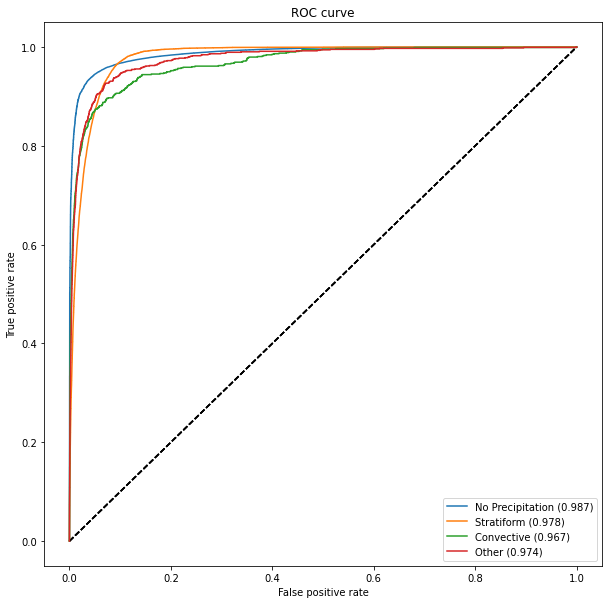

In [14]:
auc_rocs = get_roc_curve(['No Precipitation', 'Stratiform', 'Convective', 'Other'], y_test, y_pred)

# Random Forest

In [15]:
# Random Forest Hyperparameters
n_estimators = 150
max_depth = 15
bootstrap = True
criterion = 'entropy'
class_weight = 'balanced_subsample'
random_state = 42
n_job = -1

In [16]:
rfc = RandomForestClassifier(n_estimators=n_estimators, bootstrap=bootstrap, criterion=criterion,
                                  max_depth=max_depth, oob_score=False, verbose=2,
                                  class_weight=class_weight, random_state=random_state, n_jobs=n_job)

rfc.fit(X_res, y_res)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 150building tree 2 of 150

building tree 3 of 150
building tree 4 of 150
building tree 5 of 150
building tree 6 of 150
building tree 7 of 150
building tree 8 of 150
building tree 9 of 150
building tree 10 of 150
building tree 11 of 150
building tree 12 of 150
building tree 13 of 150
building tree 14 of 150
building tree 15 of 150
building tree 16 of 150
building tree 17 of 150
building tree 18 of 150
building tree 19 of 150
building tree 20 of 150
building tree 21 of 150
building tree 22 of 150
building tree 23 of 150
building tree 24 of 150
building tree 25 of 150
building tree 26 of 150
building tree 27 of 150
building tree 28 of 150
building tree 29 of 150
building tree 30 of 150
building tree 31 of 150
building tree 32 of 150
building tree 33 of 150
building tree 34 of 150
building tree 35 of 150
building tree 36 of 150
building tree 37 of 150
building tree 38 of 150


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   47.6s


building tree 39 of 150
building tree 40 of 150
building tree 41 of 150
building tree 42 of 150
building tree 43 of 150
building tree 44 of 150
building tree 45 of 150
building tree 46 of 150
building tree 47 of 150
building tree 48 of 150
building tree 49 of 150
building tree 50 of 150
building tree 51 of 150
building tree 52 of 150
building tree 53 of 150
building tree 54 of 150
building tree 55 of 150
building tree 56 of 150
building tree 57 of 150
building tree 58 of 150
building tree 59 of 150
building tree 60 of 150
building tree 61 of 150
building tree 62 of 150
building tree 63 of 150
building tree 64 of 150
building tree 65 of 150
building tree 66 of 150
building tree 67 of 150
building tree 68 of 150
building tree 69 of 150
building tree 70 of 150
building tree 71 of 150
building tree 72 of 150
building tree 73 of 150
building tree 74 of 150
building tree 75 of 150
building tree 76 of 150
building tree 77 of 150
building tree 78 of 150
building tree 79 of 150
building tree 80

[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  3.2min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=15, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=150, n_jobs=-1, oob_score=False,
                       random_state=42, verbose=2, warm_start=False)

In [17]:
y_pred = rfc.predict(X_test)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    4.0s
[Parallel(n_jobs=2)]: Done 150 out of 150 | elapsed:   15.9s finished


In [18]:
y_pred

array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       ...,
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0]])

In [19]:
y_probs = rfc.predict_proba(X_test)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    4.0s
[Parallel(n_jobs=2)]: Done 150 out of 150 | elapsed:   16.1s finished


In [20]:
print(y_probs[0][:, 1])
print(y_probs[1][:, 1])
print(y_probs[2][:, 1])
print(y_probs[3][:, 1])
print("-"*30)
y_pred_probs = np.transpose(np.array([y_probs[0][:, 1], y_probs[1][:, 1], y_probs[2][:, 1], y_probs[3][:, 1]]))
print(y_pred_probs)

[0.93411866 0.05764063 0.75572281 ... 0.98632803 1.         0.91330661]
[0.04625478 0.80387073 0.13632649 ... 0.01367197 0.         0.04260444]
[0.01295989 0.03328843 0.06971382 ... 0.         0.         0.00760849]
[0.00666667 0.10520021 0.03823688 ... 0.         0.         0.03648045]
------------------------------
[[0.93411866 0.04625478 0.01295989 0.00666667]
 [0.05764063 0.80387073 0.03328843 0.10520021]
 [0.75572281 0.13632649 0.06971382 0.03823688]
 ...
 [0.98632803 0.01367197 0.         0.        ]
 [1.         0.         0.         0.        ]
 [0.91330661 0.04260444 0.00760849 0.03648045]]


## Save and Load Model

In [21]:
# save trained model
joblib.dump(rfc, BASE_DIR + 'random_forest_with_class_weights_3_days.model')

['/content/drive/My Drive/data/NASA_2020/random_forest_with_class_weights_3_days.model']

In [22]:
# load existing model
rfc = joblib.load(BASE_DIR + 'random_forest_with_class_weights_3_days.model')

## Confusion Matrix

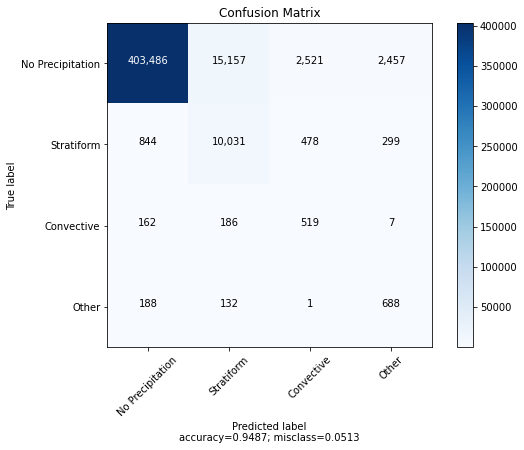

In [23]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

plot_confusion_matrix(cm           = conf_mat, 
                      normalize    = False,
                      target_names = ['No Precipitation', 'Stratiform', 'Convective', 'Other'],
                      title        = "Confusion Matrix")

## ROC Curves

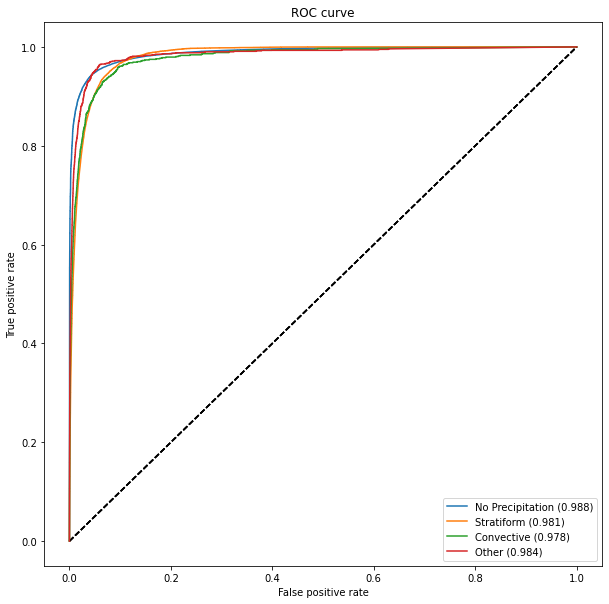

In [24]:
auc_rocs = get_roc_curve(['No Precipitation', 'Stratiform', 'Convective', 'Other'], y_test, y_pred_probs)

21


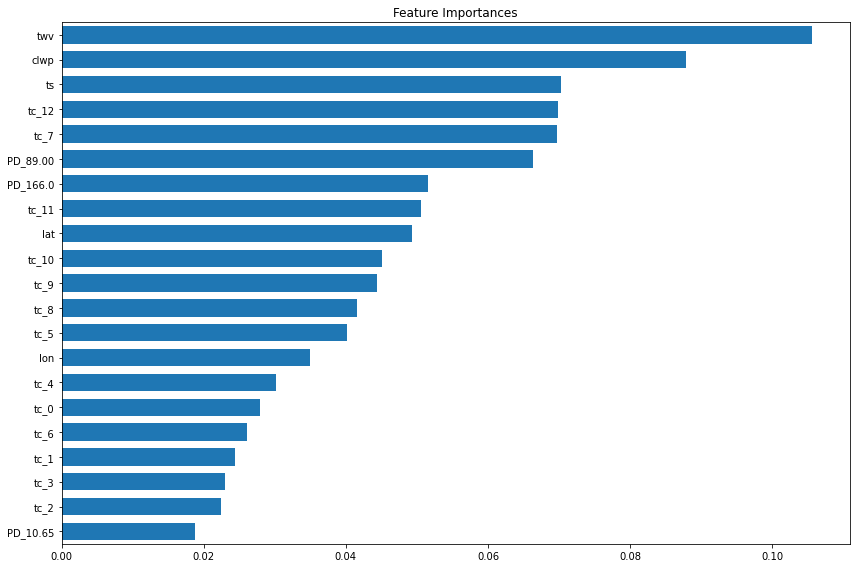

In [25]:
feature_names = np.array(['lat', 'lon',	'ts',	'clwp',	'twv', 'PD_10.65',	'PD_89.00',	'PD_166.0', 'tc_0', 'tc_1',	'tc_2', 'tc_3', 'tc_4',	'tc_5',	'tc_6',	'tc_7',	'tc_8',	'tc_9',	'tc_10', 'tc_11', 'tc_12'])
print(len(feature_names))
tree_importance_sorted_idx = np.argsort(rfc.feature_importances_)
tree_indices = np.arange(0, len(rfc.feature_importances_)) + 0.5
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 8))
ax1.barh(tree_indices,
         rfc.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticklabels(feature_names[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)
ax1.set_ylim((0, len(rfc.feature_importances_)))
plt.title('Feature Importances')
fig.tight_layout()
plt.show()